In [1]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
from l1000_evaluation_utils import compute_max_similarity
from tqdm import tqdm
import heapq
import operator

In [2]:
l1000_df = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv", index_col=0)
l1000_df

,CellLine,Time,Dose,ControlIndices,TumourIndices,SMILES,DrugIndex_maccs,DrugIndex_pharmacophore2d720,DrugIndex_morgan,"DrugIndex_morgan,pharmacophore2d720",...,primary_site_large intestine,primary_site_liver,primary_site_lung,primary_site_muscle,primary_site_ovary,primary_site_prostate,primary_site_skin,primary_site_stomach,primary_site_unknown,original_idx
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,A375,6.0,10.00,12373 12374 12375 12376 12377 12378 12379 1238...,343818 343819 343820,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,1,0,0,0
1,A549,6.0,10.00,12471 12472 12473 12474 12475 12476 12477 1247...,346328 346329,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,1,0,0,0,0,0,0,1
2,A549,24.0,10.00,12529 12530 12531 12532 12533 12534 12535 1253...,349439 349440 349441,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,1,0,0,0,0,0,0,2
3,ASC,24.0,10.00,12626 12627 12628 12629 12630 12631 12632 1263...,352969 352970 352971 352972,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,0,0,0,3
4,HA1E,6.0,10.00,3875 3876 3877 3878 3879 3880 3881 3882 3883 3...,82857 82858,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,919,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187037,VCAP,24.0,4.96,17239 17240 17241 17242 17243 17244 17245 1724...,475303 475304 475305,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NC(C)c3ccccc3)...,6652,3995,8878,8879,...,0,0,0,0,0,1,0,0,0,99309
187038,VCAP,6.0,5.01,18703 18704 18705 18706 18707 18708 18709 1871...,467715 467716 467717,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,873,...,0,0,0,0,0,1,0,0,0,99310
187039,VCAP,24.0,5.01,17239 17240 17241 17242 17243 17244 17245 1724...,475309 475310 475311,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,873,...,0,0,0,0,0,1,0,0,0,99311


In [4]:
with open("/data/ongh0068/l1000/l1000_biaae/protein_target_to_l1000_smiles.pkl", 'rb') as f:
    meta_data = pickle.load(f)
meta_data

{'AKT1': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=O)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12',
  'O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1c1c[nH]c2ccccc12',
  'COc1cc2ncnc(Nc3ccc(Oc4ccccc4)cc3)c2cc1OC',
  'O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O',
  'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1',
  'O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc3ccsc23)s1',
  'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1',
  'O=[N+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1'],
 'AKT2': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2C1)c1ccccc1',
  'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12',
  'COc1cc(OC)c(C=C2C(=O)Nc3ccccc32)c(OC)c1',
  'Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F',
  'N#CC(=Cc1ccc(O)c(O)c1)C(=O)NCc1ccccc1',
  'COc1cc(Nc2ncc(F)c(Nc

In [5]:
with open("../generation_res/test_set_sim_search.pkl", "rb") as f:
    test_set_smiles_to_train_set_diff_vector_and_distance = pickle.load(f)
test_set_smiles_to_train_set_diff_vector_and_distance

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_0': {'min_euclidean_dist': {'smile': 'CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C_4356',
   'dist': 7.569423},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_51119',
   'dist': -4.50906e-06},
  'max_cosine_sim': {'smile': 'COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1_58004',
   'dist': 2.869751e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_1': {'min_euclidean_dist': {'smile': 'CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1_10031',
   'dist': 6.8265467},
  'min_cosine_sim': {'smile': 'CC(=O)C(C#N)C(=O)Nc1cc(Br)ccc1Br_3570',
   'dist': -1.1796407e-06},
  'max_cosine_sim': {'smile': 'OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1_21393',
   'dist': 1.384695e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_2': {'min_euclidean_dist': {'smile': 'CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O_37665',
   'dist': 7.199553},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_511

In [6]:
# tmp_df = pd.DataFrame(eu_dist_similarities)
# tmp_df['dist_type'] = 'euclidean_dist'
# tmp2_df = pd.DataFrame(cosine_dist_similarities)
# tmp2_df['dist_type'] = 'cosine_dist'

In [7]:
# tmp3_df = pd.read_csv("../test_set_similarity_search_structural_similarities.csv")
# tmp3_df = pd.concat((tmp_df, tmp2_df))
# tmp3_df

,ori_smiles,dist_smiles,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.098214,0.472222,0.627219,euclidean_dist
1,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.092437,0.567568,0.494118,euclidean_dist
2,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O,0.110092,0.460526,0.237668,euclidean_dist
3,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1,0.180952,0.578313,0.796875,euclidean_dist
4,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,OC1CCCCC1N1CCC(c2ccccc2)CC1,0.113402,0.654545,0.685484,euclidean_dist
...,...,...,...,...,...,...
7670,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7671,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7672,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist
7673,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist


In [7]:
# tmp3_df.to_csv("../test_set_similarity_search_structural_similarities_with_smiles.csv")
tmp3_df = pd.read_csv('../test_set_similarity_search_structural_similarities_with_smiles.csv', index_col=0)
tmp3_df

,ori_smiles,dist_smiles,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.098214,0.472222,0.627219,euclidean_dist
1,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.092437,0.567568,0.494118,euclidean_dist
2,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O,0.110092,0.460526,0.237668,euclidean_dist
3,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1,0.180952,0.578313,0.796875,euclidean_dist
4,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,OC1CCCCC1N1CCC(c2ccccc2)CC1,0.113402,0.654545,0.685484,euclidean_dist
...,...,...,...,...,...,...
7670,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7671,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7672,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist
7673,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist


Text(0.5, 1.0, 'Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

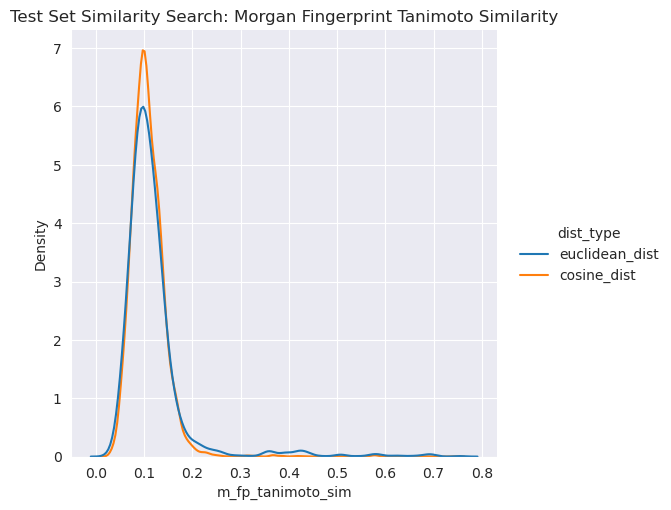

In [8]:
sns.set_style('darkgrid')
sns.displot(tmp3_df,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

In [9]:
with open("generation_res/ldm_con_vae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)

In [11]:
with open("generation_res/ldm_con_aae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_aae_data = pickle.load(f)
    


In [12]:
with open("generation_res/ldm_con_wae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_wae_data = pickle.load(f)

In [13]:
# ldm_vae_data = {k:ldm_vae_data[k] for k in list(ldm_vae_data)[:78]}
# ldm_wae_data = {k:ldm_wae_data[k] for k in list(ldm_wae_data)[:78]}
print(len(ldm_vae_data), len(ldm_aae_data), len(ldm_wae_data))

332 332 332


In [14]:
with open('/data/conghao001/FYP/drug_discovery/BiAAE/cond_generation_res/biaae_test_set_smile_to_max_sim_generated_molecule.pkl', 'rb') as f:
    biaae_data = pickle.load(f)
len(biaae_data)

419

# Filter similarity search

In [15]:
# keys = list(ldm_vae_data.keys())

keys = [k for k in ldm_vae_data.keys() if k in biaae_data.keys()]
len(keys)

332

In [16]:
aae_smiles = [k.split('_')[0] for k in keys]
aae_smiles = list(set(aae_smiles))
len(aae_smiles)

197

In [17]:
ldm_vae_data = {k:ldm_vae_data[k] for k in keys}
ldm_aae_data = {k:ldm_aae_data[k] for k in keys}
ldm_wae_data = {k:ldm_wae_data[k] for k in keys}
biaae_data = {k:biaae_data[k] for k in keys}

print(len(ldm_vae_data), len(ldm_wae_data), len(biaae_data))

332 332 332


In [18]:
from collections import defaultdict
aae_num = defaultdict(lambda: 0)
for k in keys:
    smi = k.split('_')[0]
    aae_num[smi] += 1

aae_num

defaultdict(<function __main__.<lambda>()>,
            {'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1': 2,
             'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O': 2,
             'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1': 2,
             'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC': 2,
             'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1': 2,
             'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1': 2,
             'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl': 2,
             'COc1ccc(C2CC(c3ccccc3)=NN2c2ccc(S(N)(=O)=O)cc2)cc1': 2,
             'CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1': 1,
             'Cc1ccc(S(=O)(=O)C(c2ccccc2)c2c(C)noc2C)cc1': 1,
             'CNC(=O)Nc1ccc(-c2nc(N3CC4CCC(C3)O4)c3cnn(C4CCC5(CC4)OCCO5)c3n2)cc1': 2,
             'CC(C)C(=O)NC(c1ccco1)c1ccc2cccnc2c1O': 2,
             'Cc1ccccc1C(OCCN(C)C)c1ccccc1': 1,
             'CC(=O)NC(c1ccco1)c1cc(Cl)c2cccnc2c1O': 2,
             'CC(=O)NC(c1cccs1)c1cc(Br)c2cccnc2c1O': 2,
 

In [19]:
aae_df = tmp3_df.loc[tmp3_df['ori_smiles'].isin(aae_smiles)]
aae_df

,ori_smiles,dist_smiles,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.098214,0.472222,0.627219,euclidean_dist
1,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.092437,0.567568,0.494118,euclidean_dist
2,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O,0.110092,0.460526,0.237668,euclidean_dist
3,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1,0.180952,0.578313,0.796875,euclidean_dist
4,COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1,OC1CCCCC1N1CCC(c2ccccc2)CC1,0.113402,0.654545,0.685484,euclidean_dist
...,...,...,...,...,...,...
7670,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7671,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1,0.060345,0.455882,0.243346,cosine_dist
7672,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist
7673,CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...,0.096000,0.405797,0.315113,cosine_dist


In [20]:
aae_euc = aae_df.loc[aae_df['dist_type']=='euclidean_dist']
aae_cos = aae_df.loc[aae_df['dist_type']=='cosine_dist']

### sample according to the occurance times of each ref smile
-> result in same number of scores with generated ones

In [21]:
sample_df = pd.DataFrame(columns = aae_df.columns)
sample_df

,ori_smiles,dist_smiles,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type


In [22]:
for smi in aae_smiles:
    df_euc = aae_euc.loc[aae_euc['ori_smiles']==smi].sample(n=aae_num[smi])
    df_cos = aae_cos.loc[aae_cos['ori_smiles']==smi].sample(n=aae_num[smi])
    
    sample_df = pd.concat([sample_df, df_euc, df_cos])
    
sample_df

,ori_smiles,dist_smiles,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
435,CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1...,CC(C)CC(NC(=O)C(O)C(N)Cc1ccccc1)C(=O)O,0.135135,0.390625,0.543956,euclidean_dist
426,CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1...,Cc1cc(C(=O)CN2C(=O)CCC2=O)c(C)n1Cc1ccccc1,0.117647,0.571429,0.411765,euclidean_dist
430,CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1...,COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1,0.107438,0.492537,0.333333,cosine_dist
428,CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1...,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)...,0.076923,0.569444,0.347222,cosine_dist
987,COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)c...,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,0.141935,0.623529,0.371951,euclidean_dist
...,...,...,...,...,...,...
2362,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...,0.149606,0.419753,0.515464,euclidean_dist
2365,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,C=CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(=NOCC(=O)O)c3c...,0.109489,0.406593,0.397638,cosine_dist
2367,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,CC(C)C(CO)Nc1nc(Nc2cc(N)cc(Cl)c2)c2ncn(C(C)C)c2n1,0.120000,0.500000,0.604651,cosine_dist
2660,O=C(c1ccc(Cl)cc1)N1CCN(c2ccnc3cc(Cl)ccc23)CC1,O=C(NCC1CCCCN1)c1cc(OCC(F)(F)F)ccc1OCC(F)(F)F,0.140187,0.402985,0.544554,euclidean_dist


### select the median score for each smiles
-> each ref smiles only has one score

In [23]:
ref_dict = {smi:{'morgan':0.0, 'maccs':0.0, 'fraggle':0.0} for smi in aae_smiles}
ref_df = pd.DataFrame(ref_dict).T
ref_df

,morgan,maccs,fraggle
CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1)C(C)C,0.0,0.0,0.0
COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2C1)c1ccccc1,0.0,0.0,0.0
CC(=O)Nc1ccc(NC(=S)NC(=O)c2ccc(C(C)(C)C)cc2)cc1,0.0,0.0,0.0
CC(=O)c1cccc(-c2csc3ncnc(Sc4nnnn4C)c23)c1,0.0,0.0,0.0
CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,0.0,0.0,0.0
...,...,...,...
CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1,0.0,0.0,0.0
CC(=O)Nc1ccc(CNc2ncnc3ccc(-c4c(C)noc4C)cc23)cc1,0.0,0.0,0.0
Cn1nnnc1Sc1ncnc2scc(-c3cccc(S(C)(=O)=O)c3)c12,0.0,0.0,0.0
CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,0.0,0.0,0.0


In [24]:
ref_df['morgan'] = aae_df.groupby(['ori_smiles'])['m_fp_tanimoto_sim'].median()
ref_df['maccs'] = aae_df.groupby(['ori_smiles'])['maccs_fp_tanimoto_sim'].median()
ref_df['fraggle'] = aae_df.groupby(['ori_smiles'])['fraggle_sims'].median()
ref_df

,morgan,maccs,fraggle
CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc2ncccc2c1)C(C)C,0.116788,0.455882,0.332543
COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2C1)c1ccccc1,0.112682,0.493976,0.375731
CC(=O)Nc1ccc(NC(=S)NC(=O)c2ccc(C(C)(C)C)cc2)cc1,0.094243,0.298649,0.407733
CC(=O)c1cccc(-c2csc3ncnc(Sc4nnnn4C)c23)c1,0.105729,0.405718,0.320245
CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21,0.091743,0.398211,0.288333
...,...,...,...
CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1,0.106557,0.392405,0.325587
CC(=O)Nc1ccc(CNc2ncnc3ccc(-c4c(C)noc4C)cc23)cc1,0.110834,0.512821,0.384615
Cn1nnnc1Sc1ncnc2scc(-c3cccc(S(C)(=O)=O)c3)c12,0.089858,0.364794,0.305549
CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,0.111398,0.420021,0.434217


In [25]:
def extract_sims(data):
    max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
    max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
    max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    return [max_morgan_fp_tanimoto_sim,max_maccs_fp_tanimoto_sim,max_fraggle_sim]

In [26]:
file_to_sims = {
    "ldm_vae":extract_sims(ldm_vae_data),
    "ldm_aae":extract_sims(ldm_aae_data),
    "ldm_wae":extract_sims(ldm_wae_data),
    "BiAAE":extract_sims(biaae_data),
#     "GLDM":extract_sims(ldm_aae_data)
}

for key in file_to_sims:
    file_to_sims[key].append([key for _ in range(len(file_to_sims[key][0]))])

In [28]:
tmp3_df.shape

(15350, 6)

In [29]:
# euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:78]
# cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:78]

# euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:862]
# cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:862]

euc_df = sample_df[['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims', 'dist_type']].loc[sample_df['dist_type']=='euclidean_dist']
cos_df = sample_df[['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims', 'dist_type']].loc[sample_df['dist_type']=='cosine_dist']

In [30]:
dist_df = pd.concat([euc_df, cos_df])
dist_df

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
435,0.135135,0.390625,0.543956,euclidean_dist
426,0.117647,0.571429,0.411765,euclidean_dist
987,0.141935,0.623529,0.371951,euclidean_dist
976,0.104839,0.584416,0.330986,euclidean_dist
876,0.080000,0.305085,0.546798,euclidean_dist
...,...,...,...,...
1110,0.114286,0.440000,0.326279,cosine_dist
4868,0.065359,0.236559,0.194495,cosine_dist
2365,0.109489,0.406593,0.397638,cosine_dist
2367,0.120000,0.500000,0.604651,cosine_dist


In [31]:
# ref_df = tmp3_df
dfs = []
for key in file_to_sims:
    new_df = pd.DataFrame(file_to_sims[key]).T
    new_df.columns = dist_df.columns
    dfs.append(new_df)

In [32]:
tgt = pd.concat(dfs + [dist_df])
tgt

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.185567,0.592593,0.661417,ldm_vae
1,0.290909,0.716418,0.801527,ldm_vae
2,0.172414,0.551724,0.540698,ldm_vae
3,0.234568,0.540984,0.573248,ldm_vae
4,0.204819,0.56,0.477157,ldm_vae
...,...,...,...,...
1110,0.114286,0.44,0.326279,cosine_dist
4868,0.065359,0.236559,0.194495,cosine_dist
2365,0.109489,0.406593,0.397638,cosine_dist
2367,0.12,0.5,0.604651,cosine_dist


In [34]:
def map_legend(ax):
#     leg = ax._legend
    leg = ax.get_legend()
    labels = leg.get_texts()
    for label in labels:
        text = label.get_text()
        if 'ldm' in text:
            loss = text.split('_')[1].upper()
            if loss == 'AAE':
                loss = 'GAN'
            new_text = r"GLDM ($L_{{reg}}=L_{{{}}}$)".format(loss)
            label.set_text(new_text)
    return ax

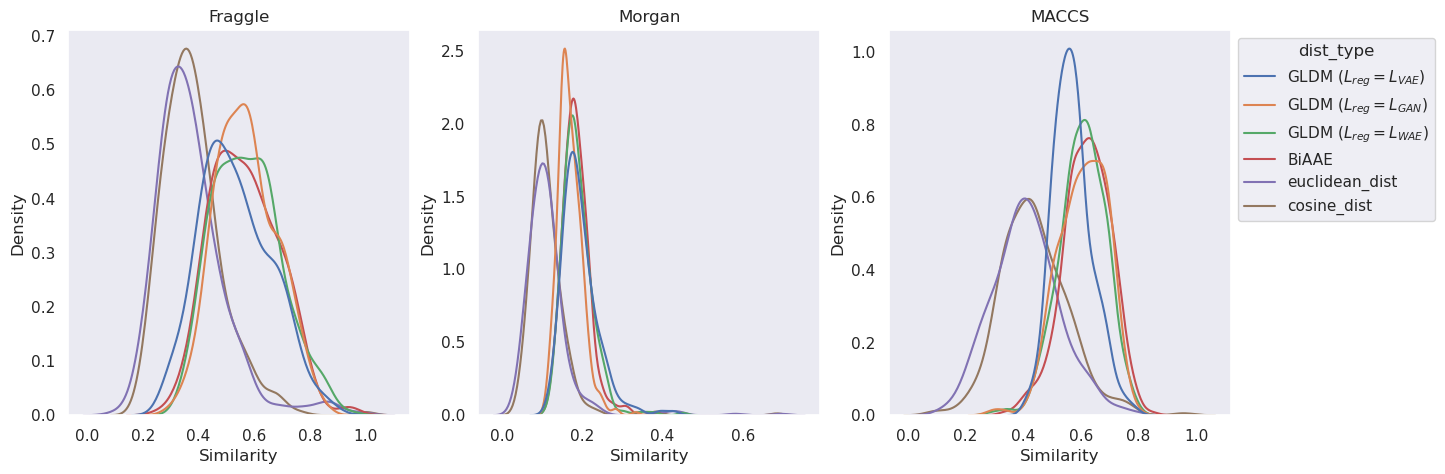

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
# print(axes)
sns.kdeplot(tgt,x = 'fraggle_sims',  hue="dist_type", ax=ax1)
# axes[0].set(title='Fraggle')
ax1.get_legend().remove()
ax1.set(xlabel='Similarity', title='Fraggle')

sns.kdeplot(tgt,x = 'm_fp_tanimoto_sim',  hue="dist_type", ax=ax2)
# axes[1].set(title='Morgan fingerprint Tanimoto Similarity')
ax2.get_legend().remove()
ax2.set(xlabel='Similarity', title='Morgan')


sns.kdeplot(tgt,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", ax=ax3)
# axes[2].set(title='MACCS fingerprint Tanimoto Similarity')
ax3.set(xlabel='Similarity', title='MACCS')
ax3 = map_legend(ax3)


sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [53]:
# fig.savefig('../test_set_similarity_search/test_set_rediscovery_correct_match_all.png', bbox_inches='tight')

# U test

In [39]:
tgt

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.185567,0.592593,0.661417,ldm_vae
1,0.290909,0.716418,0.801527,ldm_vae
2,0.172414,0.551724,0.540698,ldm_vae
3,0.234568,0.540984,0.573248,ldm_vae
4,0.204819,0.56,0.477157,ldm_vae
...,...,...,...,...
1110,0.114286,0.44,0.326279,cosine_dist
4868,0.065359,0.236559,0.194495,cosine_dist
2365,0.109489,0.406593,0.397638,cosine_dist
2367,0.12,0.5,0.604651,cosine_dist


In [40]:
from scipy.stats import mannwhitneyu

In [43]:
u1, p = mannwhitneyu(vae_maccs, euc_maccs, alternative='greater')
p

2.750768868911449e-67

In [46]:
x_type = ['ldm_vae', 'ldm_aae', 'ldm_wae']
# x_type = ['LDM(ours)']
y_type = ['BiAAE', 'euclidean_dist', 'cosine_dist']
sim_type = ['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims']

In [48]:
p_dict = {}
for sim in sim_type:
    p_dict[sim] = {} 
    for x in x_type:
        for y in y_type:
           
            x_data = tgt[sim].loc[tgt['dist_type']==x].values
            x_data = x_data.astype('float')
            y_data = tgt[sim].loc[tgt['dist_type']==y].values   
            y_data = y_data.astype('float')
            
#             print(x_data, y_data)
            u1, p = mannwhitneyu(x_data, y_data, alternative='greater')
            name = x+'-'+y
            p_dict[sim][name] = p

In [49]:
p_dict

{'m_fp_tanimoto_sim': {'ldm_vae-BiAAE': 0.019243243380970085,
  'ldm_vae-euclidean_dist': 2.3043157432274028e-83,
  'ldm_vae-cosine_dist': 1.0301489875921102e-87,
  'ldm_aae-BiAAE': 0.9999999999770639,
  'ldm_aae-euclidean_dist': 2.007324935161323e-72,
  'ldm_aae-cosine_dist': 1.6486549748756401e-74,
  'ldm_wae-BiAAE': 0.2278581789976496,
  'ldm_wae-euclidean_dist': 9.088739826920586e-83,
  'ldm_wae-cosine_dist': 5.711123532903056e-87},
 'maccs_fp_tanimoto_sim': {'ldm_vae-BiAAE': 1.0,
  'ldm_vae-euclidean_dist': 2.750768868911449e-67,
  'ldm_vae-cosine_dist': 3.368005094025491e-54,
  'ldm_aae-BiAAE': 0.9651695880618246,
  'ldm_aae-euclidean_dist': 8.635061365076603e-77,
  'ldm_aae-cosine_dist': 4.367789023079355e-66,
  'ldm_wae-BiAAE': 0.9922965987378762,
  'ldm_wae-euclidean_dist': 5.943965766252203e-77,
  'ldm_wae-cosine_dist': 8.327622244307447e-67},
 'fraggle_sims': {'ldm_vae-BiAAE': 0.9995000082155892,
  'ldm_vae-euclidean_dist': 6.6295091232765914e-52,
  'ldm_vae-cosine_dist': 1.

In [50]:
p_df = pd.DataFrame.from_dict(p_dict)
p_df

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims
ldm_vae-BiAAE,1.924324e-02,1.000000e+00,9.995000e-01
ldm_vae-euclidean_dist,2.304316e-83,2.750769e-67,6.629509e-52
ldm_vae-cosine_dist,1.030149e-87,3.368005e-54,1.889878e-50
ldm_aae-BiAAE,1.000000e+00,9.651696e-01,1.966252e-01
ldm_aae-euclidean_dist,2.007325e-72,8.635061e-77,6.360791e-71
ldm_aae-cosine_dist,1.648655e-74,4.367789e-66,8.091750e-72
ldm_wae-BiAAE,2.278582e-01,9.922966e-01,1.895291e-01
ldm_wae-euclidean_dist,9.088740e-83,5.943966e-77,2.352018e-69
ldm_wae-cosine_dist,5.711124e-87,8.327622e-67,6.073244e-70
